In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

from src.data import load_scaler
from src.cluster import load_kmeans_model
from src.model import AutoEncoder

Load and preprocess data

In [3]:
df = pd.read_csv('../data/tune_data.csv') # fraud + some normal, for threshold tuning
X = df.drop(columns=['Class']).values
y = df['Class'].values

# Preprocess: scale and assign to clusters
scaler = load_scaler()
X_scaled = scaler.transform(X)

kmeans = load_kmeans_model()
cluster_labels = kmeans.predict(X_scaled)

print(f"Total samples: {len(y)} (Normal: {(y==0).sum()}, Fraud: {(y==1).sum()})")

Total samples: 2460 (Normal: 1968, Fraud: 492)


/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Compute reconstruction errors for all clusters

In [5]:
def compute_reconstruction_errors(model, X):
    """Compute reconstruction error for each sample."""
    X_tensor = torch.tensor(X, dtype=torch.float32)

    with torch.no_grad():
        output = model(X_tensor)
        reconstructed = output['x_hat']
        errors = F.mse_loss(reconstructed, X_tensor, reduction='none').mean(dim=1)

    return errors.cpu().numpy()


# Compute errors for each cluster
cluster_data = {}

for cluster_id in range(4):
    mask = (cluster_labels == cluster_id)
    X_cluster = X_scaled[mask]
    y_cluster = y[mask]

    model = AutoEncoder.from_pretrained(cluster_id, models_dir='../models')
    errors = compute_reconstruction_errors(model, X_cluster)

    cluster_data[cluster_id] = {
        'errors': errors,
        'labels': y_cluster,
        'mask': mask
    }

    print(f"Cluster {cluster_id}: {len(y_cluster)} samples")
    print(f"  Normal mean error: {errors[y_cluster == 0].mean():.4f}")
    print(f"  Fraud mean error:  {errors[y_cluster == 1].mean():.4f}\n")

Cluster 0: 442 samples
  Normal mean error: 0.0800
  Fraud mean error:  5.2763

Cluster 1: 180 samples
  Normal mean error: 0.1390
  Fraud mean error:  3.4629

Cluster 2: 1120 samples
  Normal mean error: 0.9468
  Fraud mean error:  26.1553

Cluster 3: 718 samples
  Normal mean error: 0.1334
  Fraud mean error:  42.2426



Find optimal thresholds

In [6]:
def find_optimal_threshold(errors, y_true, n_thresholds=200):
    """Find the threshold that maximizes F1 score."""
    thresholds = np.linspace(errors.min(), errors.max(), n_thresholds)

    best_f1 = 0
    best_threshold = 0
    all_results = []

    for threshold in thresholds:
        predictions = (errors > threshold).astype(int)

        tp = ((predictions == 1) & (y_true == 1)).sum()
        fp = ((predictions == 1) & (y_true == 0)).sum()
        fn = ((predictions == 0) & (y_true == 1)).sum()

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        all_results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1, pd.DataFrame(all_results)

optimal_thresholds = []
threshold_results = {}

for cluster_id in range(4):
    errors = cluster_data[cluster_id]['errors']
    labels = cluster_data[cluster_id]['labels']

    best_thresh, best_f1, results_df = find_optimal_threshold(errors, labels)

    optimal_thresholds.append(best_thresh)
    threshold_results[cluster_id] = results_df

    print(f"Cluster {cluster_id}: threshold = {best_thresh:.4f}, F1 = {best_f1:.4f}")

print(f"\nOptimal thresholds: {optimal_thresholds}")

Cluster 0: threshold = 0.6057, F1 = 0.8442
Cluster 1: threshold = 1.1046, F1 = 0.9067
Cluster 2: threshold = 3.9564, F1 = 0.8765
Cluster 3: threshold = 1.7051, F1 = 0.9157

Optimal thresholds: [np.float32(0.6056673), np.float32(1.1045797), np.float32(3.9563997), np.float32(1.7050593)]


Visualize

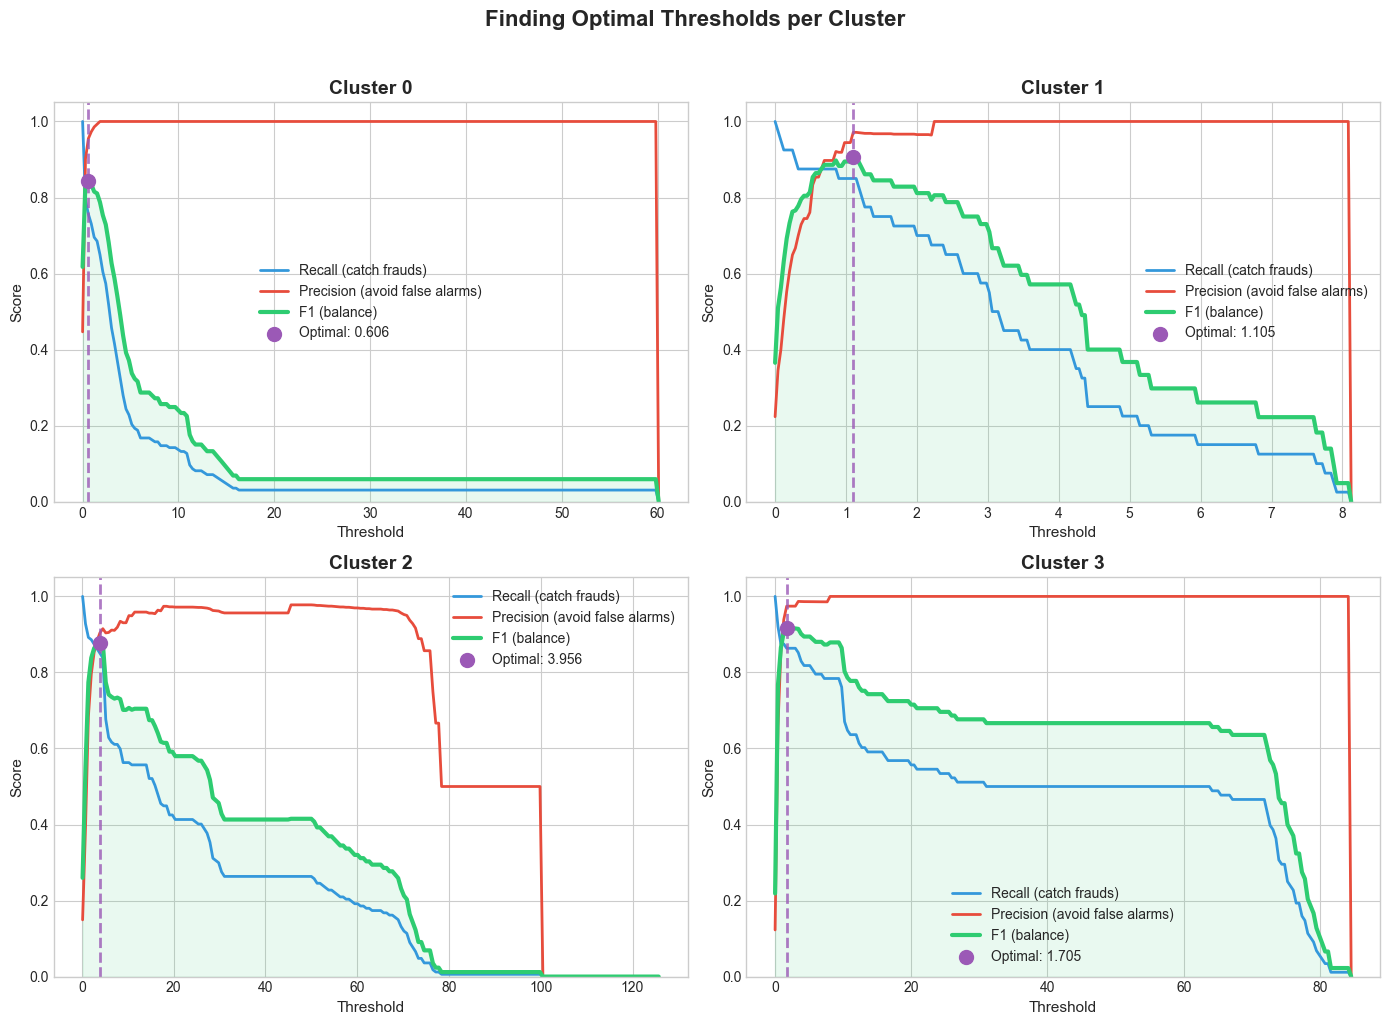

In [8]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = {'recall': '#3498db', 'precision': '#e74c3c', 'f1': '#2ecc71', 'optimal': '#9b59b6'}

for cluster_id, ax in enumerate(axes.flatten()):
    results_df = threshold_results[cluster_id]

    ax.plot(results_df['threshold'], results_df['recall'],
            label='Recall (catch frauds)', color=colors['recall'], linewidth=2)
    ax.plot(results_df['threshold'], results_df['precision'],
            label='Precision (avoid false alarms)', color=colors['precision'], linewidth=2)
    ax.plot(results_df['threshold'], results_df['f1'],
            label='F1 (balance)', color=colors['f1'], linewidth=3)

    best_thresh = optimal_thresholds[cluster_id]
    best_f1 = results_df.loc[results_df['f1'].idxmax(), 'f1']
    ax.axvline(best_thresh, color=colors['optimal'], linestyle='--', linewidth=2, alpha=0.8)
    ax.scatter([best_thresh], [best_f1], color=colors['optimal'], s=100, zorder=5,
                label=f'Optimal: {best_thresh:.3f}')

    ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Threshold', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.legend(loc='best', framealpha=0.9)
    ax.fill_between(results_df['threshold'], results_df['f1'], alpha=0.1, color=colors['f1'])

plt.suptitle('Finding Optimal Thresholds per Cluster', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Final eval with optimal thresholds

In [9]:
y_pred = np.zeros_like(y)

for cluster_id in range(4):
    errors = cluster_data[cluster_id]['errors']
    mask = cluster_data[cluster_id]['mask']
    threshold = optimal_thresholds[cluster_id]

    predictions = (errors > threshold).astype(int)
    y_pred[mask] = predictions

# Global metrics
print("Results with optimal thresholds:")
print(f"Accuracy:  {accuracy_score(y, y_pred):.4f}")
print(f"Precision: {precision_score(y, y_pred):.4f}")
print(f"Recall:    {recall_score(y, y_pred):.4f}")
print(f"F1:        {f1_score(y, y_pred):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y, y_pred)}")

Results with optimal thresholds:
Accuracy:  0.9528
Precision: 0.9413
Recall:    0.8150
F1:        0.8736

Confusion Matrix:
[[1943   25]
 [  91  401]]


Visualizing fraud vs. non-fraud transactions in each cluster (blue for non fraud, red for fraud), with the threshold indicating the point which we decide to extinguish between fraud / non-fraud (everything left of the threshold marked as non-fraud, right of threshold marked as fraud).

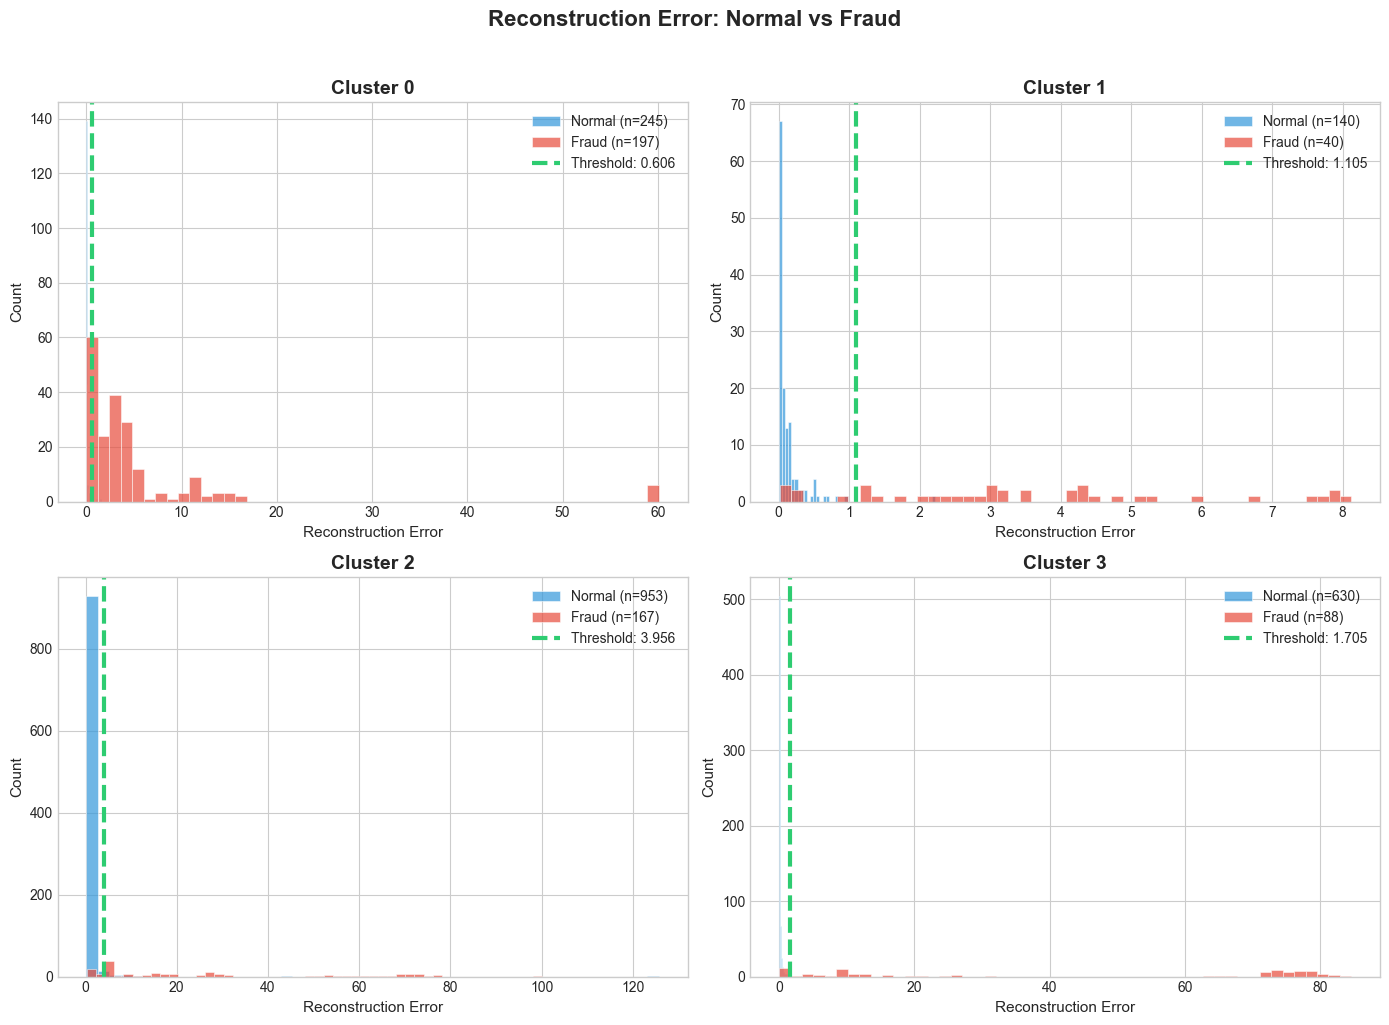

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for cluster_id, ax in enumerate(axes.flatten()):
        errors = cluster_data[cluster_id]['errors']
        labels = cluster_data[cluster_id]['labels']

        normal_errors = errors[labels == 0]
        fraud_errors = errors[labels == 1]

        ax.hist(normal_errors, bins=50, alpha=0.7, label=f'Normal (n={len(normal_errors)})',
                color='#3498db', edgecolor='white', linewidth=0.5)
        ax.hist(fraud_errors, bins=50, alpha=0.7, label=f'Fraud (n={len(fraud_errors)})',
                color='#e74c3c', edgecolor='white', linewidth=0.5)

        thresh = optimal_thresholds[cluster_id]
        ax.axvline(thresh, color='#2ecc71', linestyle='--', linewidth=3,
                        label=f'Threshold: {thresh:.3f}')

        ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Reconstruction Error', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.legend(loc='upper right', framealpha=0.9)

plt.suptitle('Reconstruction Error: Normal vs Fraud', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Final evaluation per cluster using the optimal thresholds

In [17]:
y_pred = np.zeros_like(y)


for cluster_id in range(4):
    errors = cluster_data[cluster_id]['errors']
    labels = cluster_data[cluster_id]['labels']
    mask = cluster_data[cluster_id]['mask']
    threshold = optimal_thresholds[cluster_id]

    predictions = (errors > threshold).astype(int)
    y_pred[mask] = predictions

    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions, zero_division=0)
    rec = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)

    print(f"\nCluster {cluster_id} (threshold={threshold:.4f}, n={len(labels)})")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}")


Cluster 0 (threshold=0.6057, n=442)
  Accuracy:  0.8756
  Precision: 0.9551
  Recall:    0.7563
  F1:        0.8442

Cluster 1 (threshold=1.1046, n=180)
  Accuracy:  0.9611
  Precision: 0.9714
  Recall:    0.8500
  F1:        0.9067

Cluster 2 (threshold=3.9564, n=1120)
  Accuracy:  0.9643
  Precision: 0.9045
  Recall:    0.8503
  F1:        0.8765

Cluster 3 (threshold=1.7051, n=718)
  Accuracy:  0.9805
  Precision: 0.9744
  Recall:    0.8636
  F1:        0.9157


Overall evaluation with optimal thresholds

In [18]:
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, zero_division=0)
rec = recall_score(y, y_pred, zero_division=0)
f1 = f1_score(y, y_pred, zero_division=0)
cm = confusion_matrix(y, y_pred)

print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1:         {f1:.4f}")

Accuracy:   0.9528
Precision:  0.9413
Recall:     0.8150
F1:         0.8736


Confusion matrix heatmap (2x2 með [TN, FP; FN, TP]), getum alveg tekið út en kannski næs fyrir reportið?

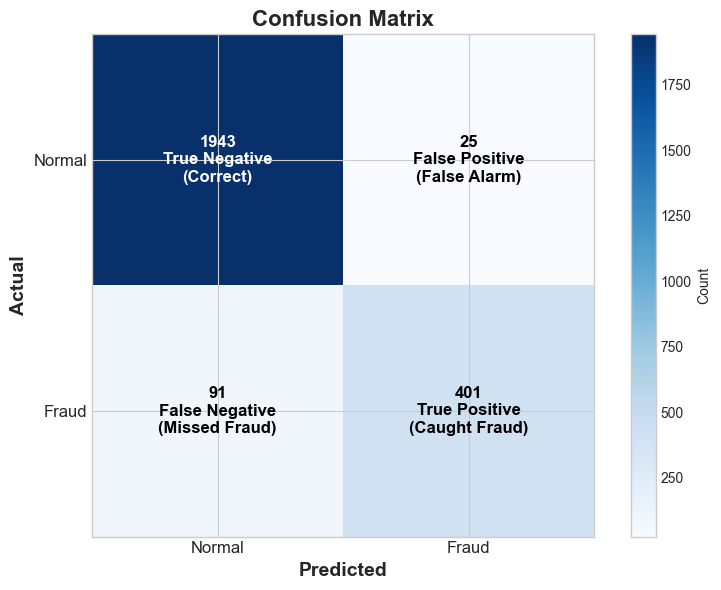

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm, cmap='Blues')

labels = [['True Negative\n(Correct)', 'False Positive\n(False Alarm)'],
        ['False Negative\n(Missed Fraud)', 'True Positive\n(Caught Fraud)']]

for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax.text(j, i, f'{cm[i, j]}\n{labels[i][j]}',
                ha='center', va='center', fontsize=12, color=color, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_yticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')

plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.show()